In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS, LocallyLinearEmbedding

sns.set(style = 'white', font_scale=1.5)

In [2]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-compass/')
from compass.tokenizer import CONCEPT_palette, CONCEPT
CONCEPT_palette = pd.DataFrame([CONCEPT_palette]).T.reset_index().sort_index(ascending=False).set_index('index')[0].to_dict()
GENESET_palette = CONCEPT.BroadCelltypePathway.map(CONCEPT_palette).to_dict()

import colorcet as cc
hue_order = list(GENESET_palette.keys())
hue_color = list(GENESET_palette.values())#sns.color_palette(cc.glasbey, n_colors= len(hue_order))

In [3]:
dfc = pd.read_csv('../01_extract_readout//TCGA/03_features_geneset.gzip', index_col=0, compression='gzip')
dfl = pd.read_csv('../01_extract_readout//TCGA/00_clinical_label_orignal.csv', index_col=0)

tcga = dfc['bcr_patient_barcode'].map(dfl['cancer_type'].apply(lambda x:x.split('-')[1])).to_frame(name='cancer_type')
tcga['domain'] = 'TCGA'
tcga_dfc = tcga.join(dfc)

dfc = pd.read_csv('../01_extract_readout//ITRP/03_features_geneset.csv.gzip', index_col=0, compression='gzip')
dfc = dfc.rename(columns = {'Index':'bcr_patient_barcode'})

dfl = pd.read_csv('../01_extract_readout//ITRP/00_clinical_label.csv', index_col=0)
itrp = dfc['bcr_patient_barcode'].map(dfl['cancer_type']).to_frame(name='cancer_type')

itrp['domain'] = 'ITRP'
itrp_dfc = itrp.join(dfc)

dfc = tcga_dfc._append(itrp_dfc)

In [ ]:
data = dfc[dfc.columns[-32:]]
mp = PCA(n_components = 2) #
pca2d = mp.fit_transform(data)
df_pca2d  = pd.DataFrame(pca2d, index=data.index, columns = ['PCA1', 'PCA2'])

In [5]:
mp = UMAP(n_components = 2, n_neighbors=200,  min_dist=0.5, random_state = 42,   verbose=1 ) #

umap2d = mp.fit_transform(data)
df_umap2d  = pd.DataFrame(umap2d, index=data.index, columns = ['UMAP1', 'UMAP2'])

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.5, n_neighbors=200, random_state=42, verbose=1)
Wed Jun  5 11:26:32 2024 Construct fuzzy simplicial set
Wed Jun  5 11:26:32 2024 Finding Nearest Neighbors
Wed Jun  5 11:26:32 2024 Building RP forest with 64 trees
Wed Jun  5 11:26:44 2024 NN descent for 21 iterations
	 1  /  21
	 2  /  21
	Stopping threshold met -- exiting after 2 iterations
Wed Jun  5 11:51:26 2024 Finished Nearest Neighbor Search
Wed Jun  5 11:54:40 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Jun  5 21:48:41 2024 Finished embedding


In [ ]:
ls

In [6]:
df2d = dfc[['cancer_type', 'domain', 'bcr_patient_barcode', 'feature_name']].join(df_pca2d).join(df_umap2d)
df2d.to_csv('geneset_space.csv.gzip', compression='gzip')

In [3]:
df2d = pd.read_csv('geneset_space.csv.gzip', index_col=0,  compression='gzip')

In [4]:

from matplotlib.ticker import MaxNLocator


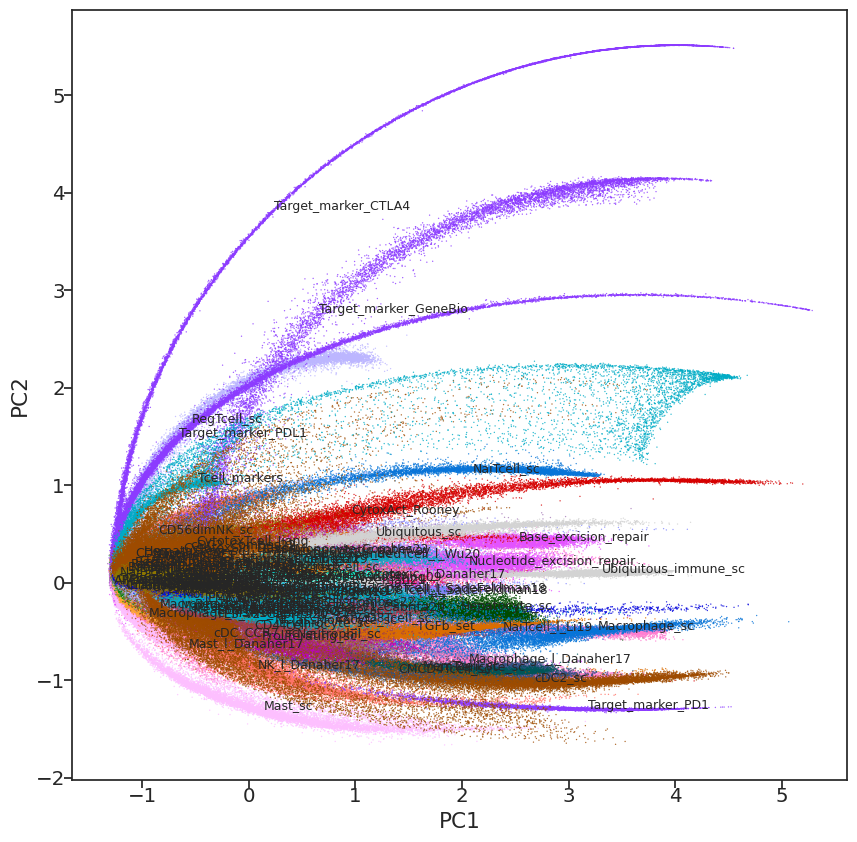

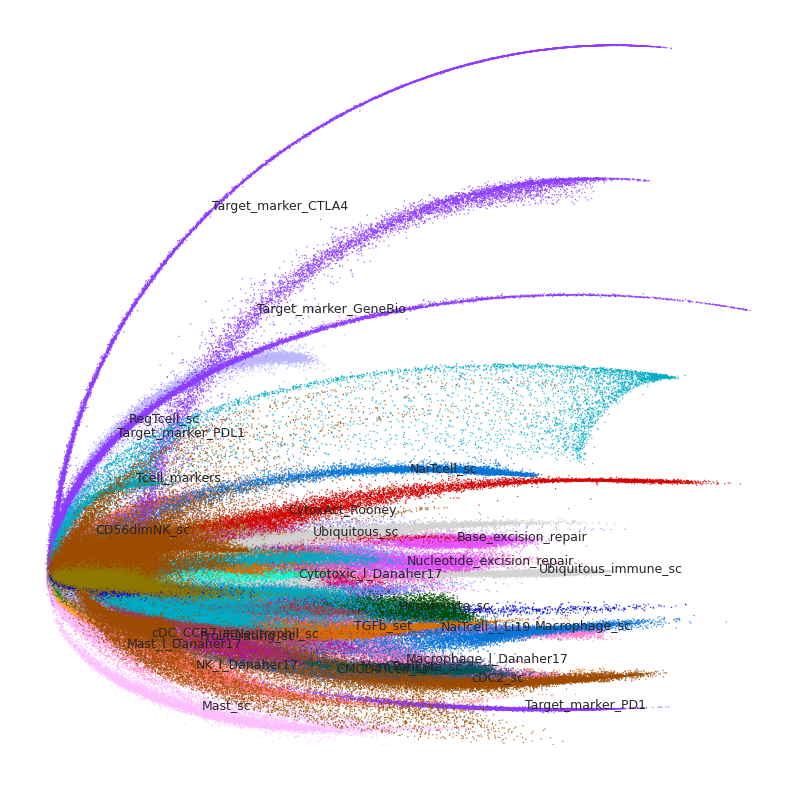

In [21]:
dfp = df2d[df2d.domain == 'TCGA']

fig, ax = plt.subplots(figsize=(10, 10))

x = 'PCA1'
y = 'PCA2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 1, 
                 ax=ax, legend=False)

mean = dfp.groupby(hue)[[x,y]].median()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':9})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

#fig.savefig('genset_TCGA_PCA_labelled.pdf')


dfp = df2d[df2d.domain == 'TCGA']

fig, ax = plt.subplots(figsize=(10, 10))

x = 'PCA1'
y = 'PCA2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 1, 
                 ax=ax, legend=False)

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

ax.set_xlabel('')
ax.set_ylabel('')

plt.axis('off')



m1 = dfp.groupby(hue)[[x]].median()
m2 = dfp.groupby(hue)[[y]].median()

for name in m1.index:
    s = m1.loc[name]
    sy = m2.loc[name]
    if (s[x] > 1) | (abs(sy[y]) > 0.5):
        ax.text(s[x], sy[y], name,  fontdict={'fontsize':9})


fig.savefig('genset_TCGA_PCA_unlabelled.jpg', bbox_inches ='tight', dpi = 400)

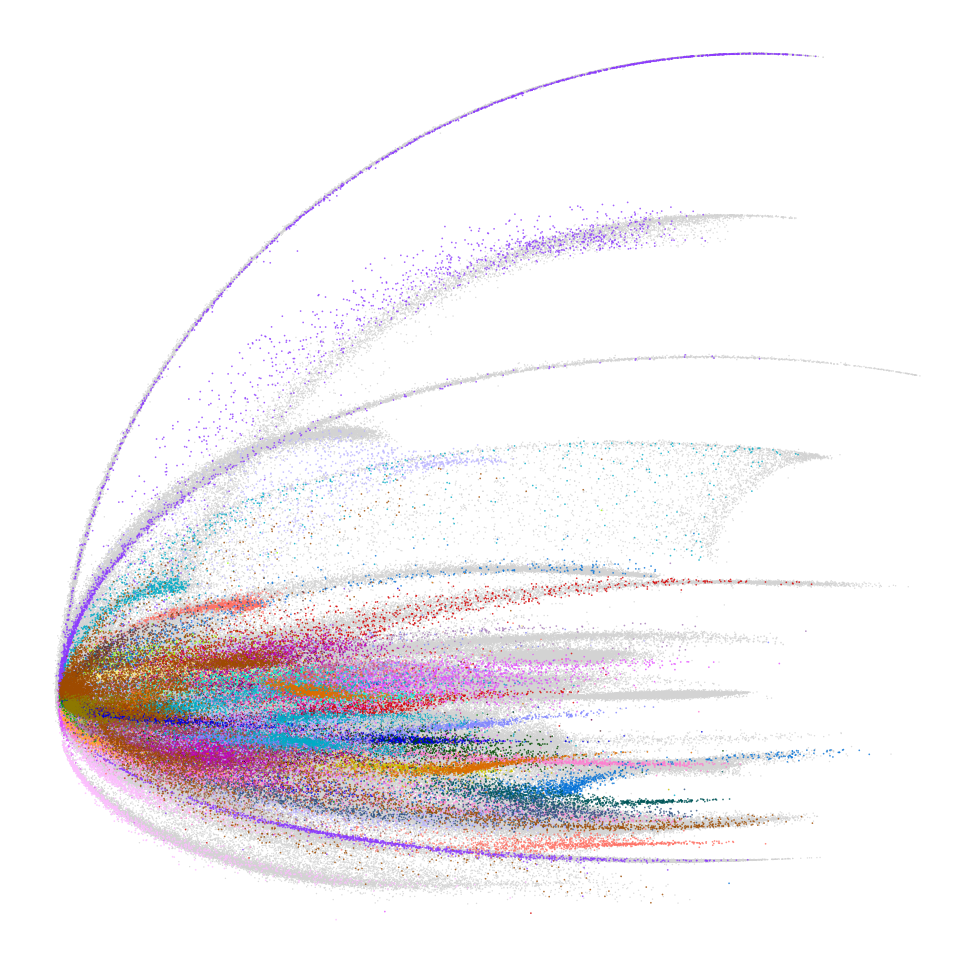

In [6]:
dfp1 = df2d[df2d.domain == 'TCGA']
dfp2 = df2d[df2d.domain == 'ITRP']

fig, ax = plt.subplots(figsize=(10, 10))


background_color = {i:'#d3d3d3' for i in hue_order}
overlay_color = hue_color #{i:'#ff00ff' for i in hue_order}


x = 'PCA1'
y = 'PCA2'
hue = 'feature_name'

sns.scatterplot(data = dfp1, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=background_color, s = 1, 
                 ax=ax, legend=False)


sns.scatterplot(data = dfp2, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 1.5, 
                 ax=ax, legend=False)

# mean = dfp.groupby(hue)[[x,y]].median()
# for name in mean.index:
#     s = mean.loc[name]
#     ax.text(s[x], s[y], name,  fontdict={'fontsize':9})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('')
ax.set_ylabel('')
plt.axis('off')
plt.tight_layout()
fig.savefig('geneset_ITRP_PCA_labelled.pdf.jpg', bbox_inches ='tight', dpi = 400)

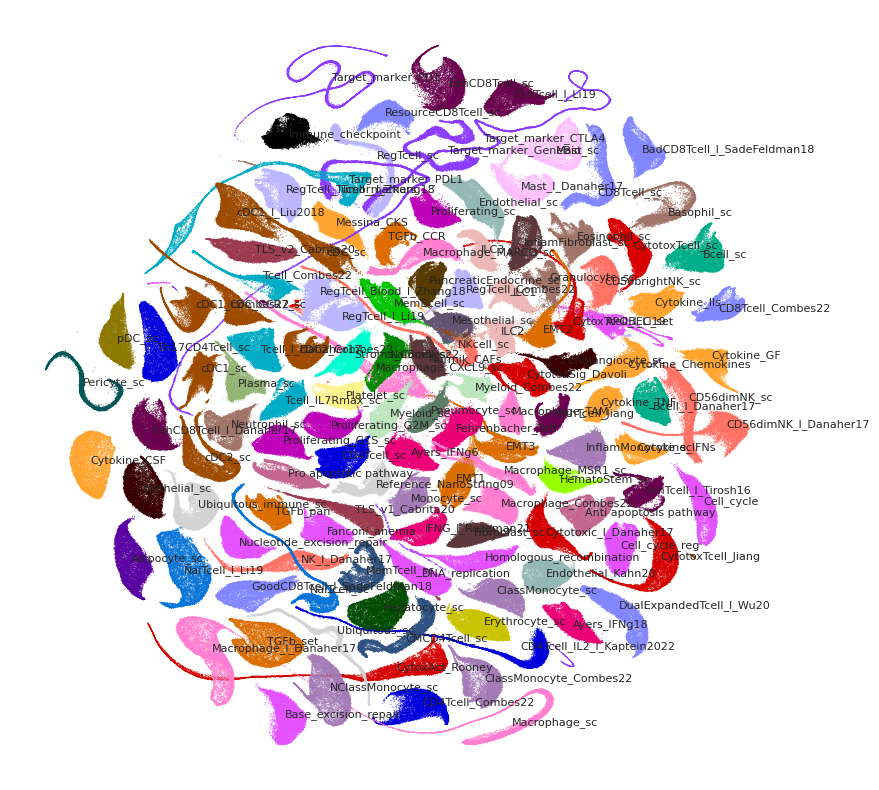

In [8]:
dfp = df2d[df2d.domain == 'TCGA']

fig, ax = plt.subplots(figsize=(10, 10))

x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 0.5, 
                 ax=ax, legend=False)

mean = dfp.groupby(hue)[[x,y]].median()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':8})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('')
ax.set_ylabel('')
plt.axis('off')

fig.savefig('geneset_TCGA_UMAP_labelled.jpg', bbox_inches ='tight', dpi = 400)

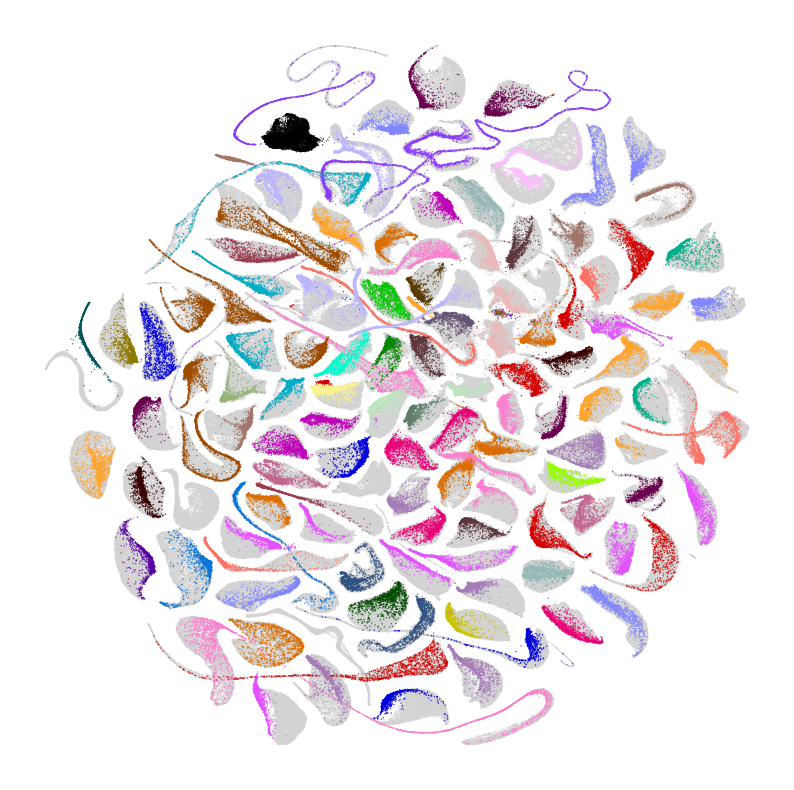

In [22]:
dfp1 = df2d[df2d.domain == 'TCGA']
dfp2 = df2d[df2d.domain == 'ITRP']

fig, ax = plt.subplots(figsize=(10, 10))


background_color = {i:'#d3d3d3' for i in hue_order}
overlay_color = hue_color #{i:'#ff00ff' for i in hue_order}


x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp1, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=background_color, s = 0.5, 
                 ax=ax, legend=False)


sns.scatterplot(data = dfp2, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=hue_color, s = 1, 
                 ax=ax, legend=False)

# mean = dfp.groupby(hue)[[x,y]].median()
# for name in mean.index:
#     s = mean.loc[name]
#     ax.text(s[x], s[y], name,  fontdict={'fontsize':9})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('')
ax.set_ylabel('')
plt.axis('off')

fig.savefig('geneset_ITRP_UMAP_labelled.pdf.jpg', bbox_inches ='tight', dpi = 400)

In [11]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


def add_legend(ax, markersize = 1):
    handles = []
    point1 = Line2D([0], [0], label='TCGA', marker='o', markersize=markersize, 
             markeredgecolor=list(background_color.values())[0], linestyle='',
                   markerfacecolor=list(background_color.values())[0],)
    
    point2 = Line2D([0], [0], label='ITRP', marker='o', markersize=markersize, 
             markeredgecolor=list(overlay_color.values())[0], linestyle='',
                   markerfacecolor=list(overlay_color.values())[0],)
    
    # add manual symbols to auto legend
    handles.extend([point1, point2])
    
    ax.legend(handles=handles, numpoints=5)
    

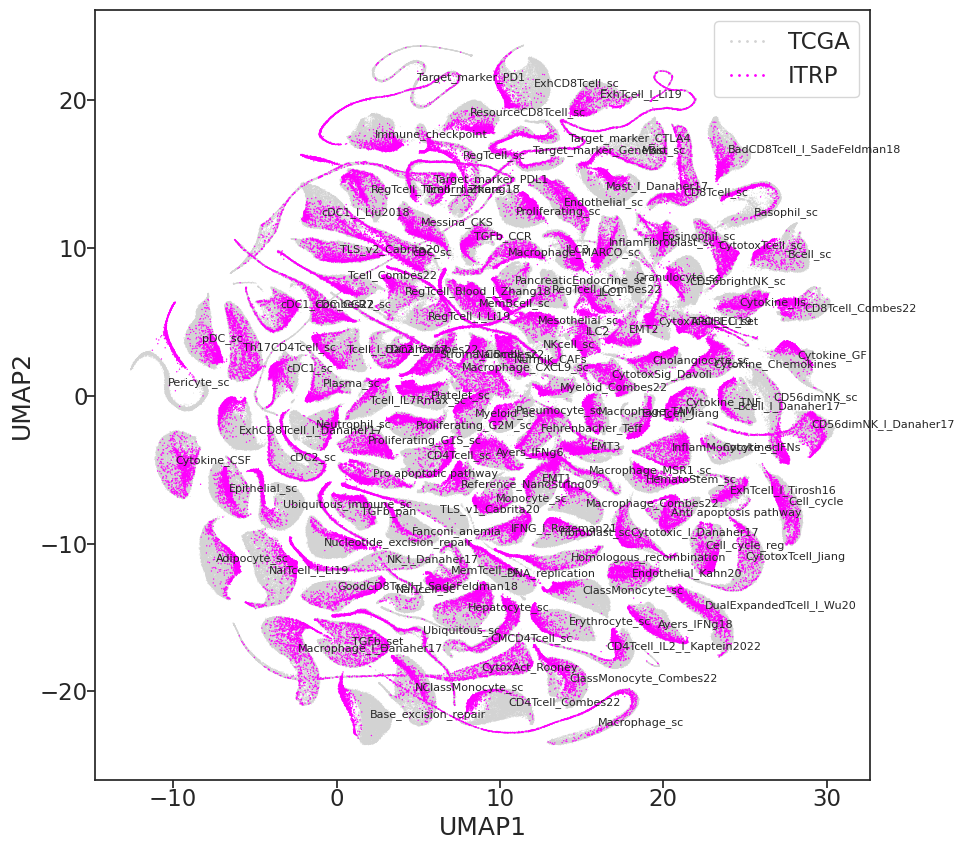

In [12]:
dfp1 = df2d[df2d.domain == 'TCGA']
dfp2 = df2d[df2d.domain == 'ITRP']

background_color = {i:'#d3d3d3' for i in hue_order}
overlay_color = {i:'#ff00ff' for i in hue_order}

fig, ax = plt.subplots(figsize=(10, 10))

x = 'UMAP1'
y = 'UMAP2'
hue = 'feature_name'

sns.scatterplot(data = dfp1, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=background_color, s = 0.5, 
                 ax=ax, legend=False)

sns.scatterplot(data = dfp2, x = x, y = y, hue = hue,  alpha = 1,
                linewidth=0.0, hue_order = hue_order, palette=overlay_color, s = 1, 
                 ax=ax, legend=False)


add_legend(ax)


mean = dfp1.groupby(hue)[[x,y]].median()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':8})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

#fig.savefig('geneset_overlay_UMAP_labelled.pdf', bbox_inches ='tight')

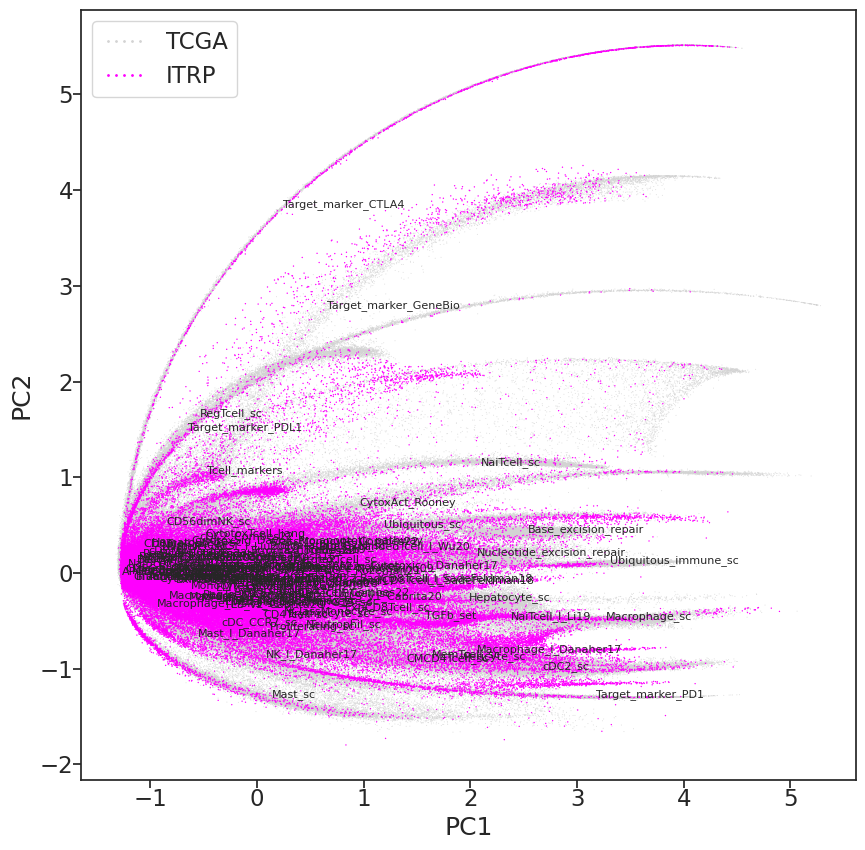

In [13]:
dfp1 = df2d[df2d.domain == 'TCGA']
dfp2 = df2d[df2d.domain == 'ITRP']

background_color = {i:'#d3d3d3' for i in hue_order}
overlay_color = {i:'#ff00ff' for i in hue_order}

fig, ax = plt.subplots(figsize=(10, 10))

x = 'PCA1'
y = 'PCA2'
hue = 'feature_name'

sns.scatterplot(data = dfp1, x = x, y = y, hue = hue,  alpha = 0.8,
                linewidth=0.0, hue_order = hue_order, palette=background_color, s = 0.5, 
                 ax=ax, legend=False)

sns.scatterplot(data = dfp2, x = x, y = y, hue = hue,  alpha = 1,
                linewidth=0.0, hue_order = hue_order, palette=overlay_color, s = 1, 
                 ax=ax, legend=False)

add_legend(ax)

mean = dfp1.groupby(hue)[[x,y]].median()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s[x], s[y], name,  fontdict={'fontsize':8})

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

#fig.savefig('geneset_overlay_PCA_labelled.pdf', bbox_inches ='tight')

In [ ]:
ls